In [41]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import (
    accuracy_score, f1_score, roc_auc_score, average_precision_score,
    classification_report, confusion_matrix, roc_curve, precision_recall_curve
)
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import (
    RandomForestClassifier, 
    HistGradientBoostingClassifier,
    StackingClassifier
)
from sklearn.inspection import permutation_importance
import joblib
import json
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

In [2]:
df = pd.read_csv("S06-hw-dataset-04.csv", sep=",")

print("Первые 5 строк:")
print(df.head())

Первые 5 строк:
   id       f01       f02       f03       f04       f05       f06       f07  \
0   1 -1.250210  1.423474 -0.225004 -4.023138 -0.832729 -0.550874  1.772090   
1   2  0.074328  0.376429  0.212831 -0.502074  2.017405  0.625496  1.943785   
2   3  0.638481  0.060968  0.746760  2.479653 -0.292858 -0.078139 -2.918423   
3   4  1.712916 -1.350969 -0.256473  1.622074 -0.445141  0.911932 -3.440345   
4   5  0.905676 -0.206545 -0.068806  4.086026 -1.010045 -0.772644 -4.207688   

        f08       f09  ...        f52        f53       f54       f55  \
0  2.761690 -0.698750  ...  10.938269   0.501178  1.600001  0.314212   
1  1.242030 -0.524090  ...   7.775262  -4.550195  6.272586 -0.932162   
2 -0.013186  1.009135  ...  -4.448447  -9.593179 -3.093519  0.029321   
3  1.505192 -1.104348  ...  -1.619072  -3.237479 -5.474038 -1.582475   
4  2.506104  1.589143  ...  -2.396844 -10.540129 -5.532811 -1.231203   

        f56       f57       f58       f59       f60  target  
0  1.209735  1

In [3]:
print("\nИнформация о датафрейме:")
print(df.info())


Информация о датафрейме:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25000 entries, 0 to 24999
Data columns (total 62 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   id      25000 non-null  int64  
 1   f01     25000 non-null  float64
 2   f02     25000 non-null  float64
 3   f03     25000 non-null  float64
 4   f04     25000 non-null  float64
 5   f05     25000 non-null  float64
 6   f06     25000 non-null  float64
 7   f07     25000 non-null  float64
 8   f08     25000 non-null  float64
 9   f09     25000 non-null  float64
 10  f10     25000 non-null  float64
 11  f11     25000 non-null  float64
 12  f12     25000 non-null  float64
 13  f13     25000 non-null  float64
 14  f14     25000 non-null  float64
 15  f15     25000 non-null  float64
 16  f16     25000 non-null  float64
 17  f17     25000 non-null  float64
 18  f18     25000 non-null  float64
 19  f19     25000 non-null  float64
 20  f20     25000 non-null  float64
 21  f21     2

In [4]:
print("\nОписательные статистики:")
print(df.describe())


Описательные статистики:
                 id           f01           f02           f03           f04  \
count  25000.000000  25000.000000  25000.000000  25000.000000  25000.000000   
mean   12500.500000     -0.000386     -0.004872      0.003202      0.335329   
std     7217.022701      1.001623      0.995606      1.004367      3.207537   
min        1.000000     -4.370993     -4.087073     -4.103875    -13.249937   
25%     6250.750000     -0.680165     -0.675100     -0.675426     -1.750048   
50%    12500.500000      0.001859     -0.000247      0.013272      0.403483   
75%    18750.250000      0.679702      0.659523      0.683437      2.486453   
max    25000.000000      4.208888      3.984564      3.793442     15.288250   

                f05           f06           f07           f08           f09  \
count  25000.000000  25000.000000  25000.000000  25000.000000  25000.000000   
mean      -0.000563     -0.010118      0.001182      0.957385     -0.004658   
std        0.993965      

In [5]:
print("\nРаспределение целевой переменной:")
print(df['target'].value_counts(normalize=True))


Распределение целевой переменной:
target
0    0.9508
1    0.0492
Name: proportion, dtype: float64


In [ ]:
missing_values = df.isnull().sum()
print(f"\nПропущенные значения: {missing_values.sum()}")


Пропущенные значения: 0


In [ ]:
X = df.drop(['target', 'id'], axis=1)
y = df['target']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, 
    test_size=0.2, 
    random_state=RANDOM_STATE, 
    stratify=y
)

print(f"Размер обучающей выборки: {X_train.shape}")
print(f"Размер тестовой выборки: {X_test.shape}")

Размер обучающей выборки: (20000, 60)
Размер тестовой выборки: (5000, 60)


Фиксированный seed гарантирует воспроизводимость эксперимента — одинаковые разбиения данных при каждом запуске для корректного сравнения моделей.

Стратификация сохраняет пропорции классов в train/test выборках, что критически важно при дисбалансе (95/5), иначе можно получить тест почти без миноритарного класса и завышенные метрики.



In [ ]:
all_metrics = {}

dummy = DummyClassifier(strategy='most_frequent', random_state=RANDOM_STATE)
dummy.fit(X_train, y_train)
y_pred_dummy = dummy.predict(X_test)
y_proba_dummy = dummy.predict_proba(X_test)[:, 1]

dummy_metrics = {
    'accuracy': accuracy_score(y_test, y_pred_dummy),
    'f1': f1_score(y_test, y_pred_dummy),
    'roc_auc': roc_auc_score(y_test, y_proba_dummy),
    'avg_precision': average_precision_score(y_test, y_proba_dummy)
}

all_metrics['DummyClassifier'] = dummy_metrics

print("DummyClassifier (most_frequent):")
print(f"Accuracy: {dummy_metrics['accuracy']:.4f}")
print(f"F1: {dummy_metrics['f1']:.4f}")
print(f"ROC-AUC: {dummy_metrics['roc_auc']:.4f}")
print(f"Average Precision: {dummy_metrics['avg_precision']:.4f}")


DummyClassifier (most_frequent):
Accuracy: 0.9508
F1: 0.0000
ROC-AUC: 0.5000
Average Precision: 0.0492


In [ ]:
logreg_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('logreg', LogisticRegression(
        class_weight='balanced', # Учитываем дисбаланс
        random_state=RANDOM_STATE,
        max_iter=1000
    ))
])

logreg_pipeline.fit(X_train, y_train)
y_pred_logreg = logreg_pipeline.predict(X_test)
y_proba_logreg = logreg_pipeline.predict_proba(X_test)[:, 1]

logreg_metrics = {
    'accuracy': accuracy_score(y_test, y_pred_logreg),
    'f1': f1_score(y_test, y_pred_logreg),
    'roc_auc': roc_auc_score(y_test, y_proba_logreg),
    'avg_precision': average_precision_score(y_test, y_proba_logreg)
}

all_metrics['LogisticRegression'] = logreg_metrics

print("LogisticRegression (с балансировкой классов):")
print(f"Accuracy: {logreg_metrics['accuracy']:.4f}")
print(f"F1: {logreg_metrics['f1']:.4f}")
print(f"ROC-AUC: {logreg_metrics['roc_auc']:.4f}")
print(f"Average Precision: {logreg_metrics['avg_precision']:.4f}")

LogisticRegression (с балансировкой классов):
Accuracy: 0.7756
F1: 0.2540
ROC-AUC: 0.8355
Average Precision: 0.4582


In [ ]:
dt_params = {
    'max_depth': [3, 5, 7, 10, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4, 10],
    'class_weight': ['balanced', None]
}

dt_grid = GridSearchCV(
    DecisionTreeClassifier(random_state=RANDOM_STATE),
    dt_params,
    cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE),
    scoring='roc_auc',
    n_jobs=-1,
    verbose=1
)

dt_grid.fit(X_train, y_train)

print("Лучшие параметры для DecisionTree:")
print(dt_grid.best_params_)

dt_best = dt_grid.best_estimator_
y_pred_dt = dt_best.predict(X_test)
y_proba_dt = dt_best.predict_proba(X_test)[:, 1]

dt_metrics = {
    'accuracy': accuracy_score(y_test, y_pred_dt),
    'f1': f1_score(y_test, y_pred_dt),
    'roc_auc': roc_auc_score(y_test, y_proba_dt),
    'avg_precision': average_precision_score(y_test, y_proba_dt)
}

all_metrics['DecisionTree'] = dt_metrics

print("\nDecisionTreeClassifier:")
print(f"Accuracy: {dt_metrics['accuracy']:.4f}")
print(f"F1: {dt_metrics['f1']:.4f}")
print(f"ROC-AUC: {dt_metrics['roc_auc']:.4f}")
print(f"Average Precision: {dt_metrics['avg_precision']:.4f}")

Fitting 5 folds for each of 120 candidates, totalling 600 fits
Лучшие параметры для DecisionTree:
{'class_weight': 'balanced', 'max_depth': 5, 'min_samples_leaf': 10, 'min_samples_split': 2}

DecisionTreeClassifier:
Accuracy: 0.8798
F1: 0.3746
ROC-AUC: 0.8277
Average Precision: 0.3272


In [ ]:
rf_params = {
    'n_estimators': [100, 200],
    'max_depth': [10, 20, None],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2, 4],
    'class_weight': ['balanced', 'balanced_subsample', None],
    'max_features': ['sqrt', 'log2', 0.5]
}

rf_grid = GridSearchCV(
    RandomForestClassifier(random_state=RANDOM_STATE, n_jobs=-1),
    rf_params,
    cv=StratifiedKFold(n_splits=3, shuffle=True, random_state=RANDOM_STATE),  # Меньше фолдов из-за времени
    scoring='roc_auc',
    n_jobs=-1,
    verbose=1
)

rf_grid.fit(X_train, y_train)

print("Лучшие параметры для RandomForest:")
print(rf_grid.best_params_)

rf_best = rf_grid.best_estimator_
y_pred_rf = rf_best.predict(X_test)
y_proba_rf = rf_best.predict_proba(X_test)[:, 1]

rf_metrics = {
    'accuracy': accuracy_score(y_test, y_pred_rf),
    'f1': f1_score(y_test, y_pred_rf),
    'roc_auc': roc_auc_score(y_test, y_proba_rf),
    'avg_precision': average_precision_score(y_test, y_proba_rf)
}

all_metrics['RandomForest'] = rf_metrics

print("\nRandomForestClassifier:")
print(f"Accuracy: {rf_metrics['accuracy']:.4f}")
print(f"F1: {rf_metrics['f1']:.4f}")
print(f"ROC-AUC: {rf_metrics['roc_auc']:.4f}")
print(f"Average Precision: {rf_metrics['avg_precision']:.4f}")


Fitting 3 folds for each of 324 candidates, totalling 972 fits
Лучшие параметры для RandomForest:
{'class_weight': 'balanced', 'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 200}

RandomForestClassifier:
Accuracy: 0.9724
F1: 0.6102
ROC-AUC: 0.8940
Average Precision: 0.7934


In [ ]:
hgb_params = {
    'max_iter': [100, 200],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.05, 0.1, 0.2],
    'min_samples_leaf': [10, 20, 30],
    'l2_regularization': [0, 0.1, 1],
    'max_bins': [128, 255]
} 

hgb_grid = GridSearchCV(
    HistGradientBoostingClassifier(
        random_state=RANDOM_STATE,
        early_stopping=True,
        validation_fraction=0.1,
        scoring='roc_auc'
    ),
    hgb_params,
    cv=StratifiedKFold(n_splits=3, shuffle=True, random_state=RANDOM_STATE),
    scoring='roc_auc',
    n_jobs=-1,
    verbose=1
)

hgb_grid.fit(X_train, y_train)

print("Лучшие параметры для HistGradientBoosting:")
print(hgb_grid.best_params_)

hgb_best = hgb_grid.best_estimator_
y_pred_hgb = hgb_best.predict(X_test)
y_proba_hgb = hgb_best.predict_proba(X_test)[:, 1]

hgb_metrics = {
    'accuracy': accuracy_score(y_test, y_pred_hgb),
    'f1': f1_score(y_test, y_pred_hgb),
    'roc_auc': roc_auc_score(y_test, y_proba_hgb),
    'avg_precision': average_precision_score(y_test, y_proba_hgb)
}

all_metrics['HistGradientBoosting'] = hgb_metrics

print("\nHistGradientBoostingClassifier:")
print(f"Accuracy: {hgb_metrics['accuracy']:.4f}")
print(f"F1: {hgb_metrics['f1']:.4f}")
print(f"ROC-AUC: {hgb_metrics['roc_auc']:.4f}")
print(f"Average Precision: {hgb_metrics['avg_precision']:.4f}")


Fitting 3 folds for each of 324 candidates, totalling 972 fits
Лучшие параметры для HistGradientBoosting:
{'l2_regularization': 1, 'learning_rate': 0.05, 'max_bins': 128, 'max_depth': 5, 'max_iter': 200, 'min_samples_leaf': 10}

HistGradientBoostingClassifier:
Accuracy: 0.9784
F1: 0.7245
ROC-AUC: 0.8904
Average Precision: 0.7745


In [30]:
base_models = [
    ('dt', DecisionTreeClassifier(
        max_depth=5,
        min_samples_leaf=10,
        class_weight='balanced',
        random_state=RANDOM_STATE
    )),
    ('rf', RandomForestClassifier(
        n_estimators=100,
        max_depth=10,
        min_samples_leaf=4,
        class_weight='balanced_subsample',
        random_state=RANDOM_STATE,
        n_jobs=-1
    )),
    ('hgb', HistGradientBoostingClassifier(
        max_iter=100,
        max_depth=5,
        learning_rate=0.1,
        min_samples_leaf=20,
        random_state=RANDOM_STATE,
        early_stopping=True,
        validation_fraction=0.1
    ))
]

# Мета-модель
meta_model = LogisticRegression(
    class_weight='balanced',
    random_state=RANDOM_STATE,
    max_iter=1000
)

# StackingClassifier
stacking = StackingClassifier(
    estimators=base_models,
    final_estimator=meta_model,
    cv=StratifiedKFold(n_splits=3, shuffle=True, random_state=RANDOM_STATE),
    n_jobs=-1,
    passthrough=False  # Используем только предсказания базовых моделей
)

In [31]:
stacking.fit(X_train, y_train)

# Предсказания
y_pred_stacking = stacking.predict(X_test)
y_proba_stacking = stacking.predict_proba(X_test)[:, 1]

# Метрики
stacking_metrics = {
    'accuracy': accuracy_score(y_test, y_pred_stacking),
    'f1': f1_score(y_test, y_pred_stacking),
    'roc_auc': roc_auc_score(y_test, y_proba_stacking),
    'avg_precision': average_precision_score(y_test, y_proba_stacking)
}

all_metrics['Stacking'] = stacking_metrics

print("StackingClassifier:")
print(f"Accuracy: {stacking_metrics['accuracy']:.4f}")
print(f"F1: {stacking_metrics['f1']:.4f}")
print(f"ROC-AUC: {stacking_metrics['roc_auc']:.4f}")
print(f"Average Precision: {stacking_metrics['avg_precision']:.4f}")

StackingClassifier:
Accuracy: 0.9424
F1: 0.5765
ROC-AUC: 0.9015
Average Precision: 0.7843


Сравнение метрик всех моделей:


,accuracy,f1,roc_auc,avg_precision
Stacking,0.9424,0.576471,0.901535,0.784251
RandomForest,0.9724,0.610169,0.894019,0.793363
HistGradientBoosting,0.9784,0.724490,0.890388,0.774461
LogisticRegression,0.7756,0.253989,0.835505,0.458232
DecisionTree,0.8798,0.374610,0.827704,0.327203
DummyClassifier,0.9508,0.000000,0.500000,0.049200


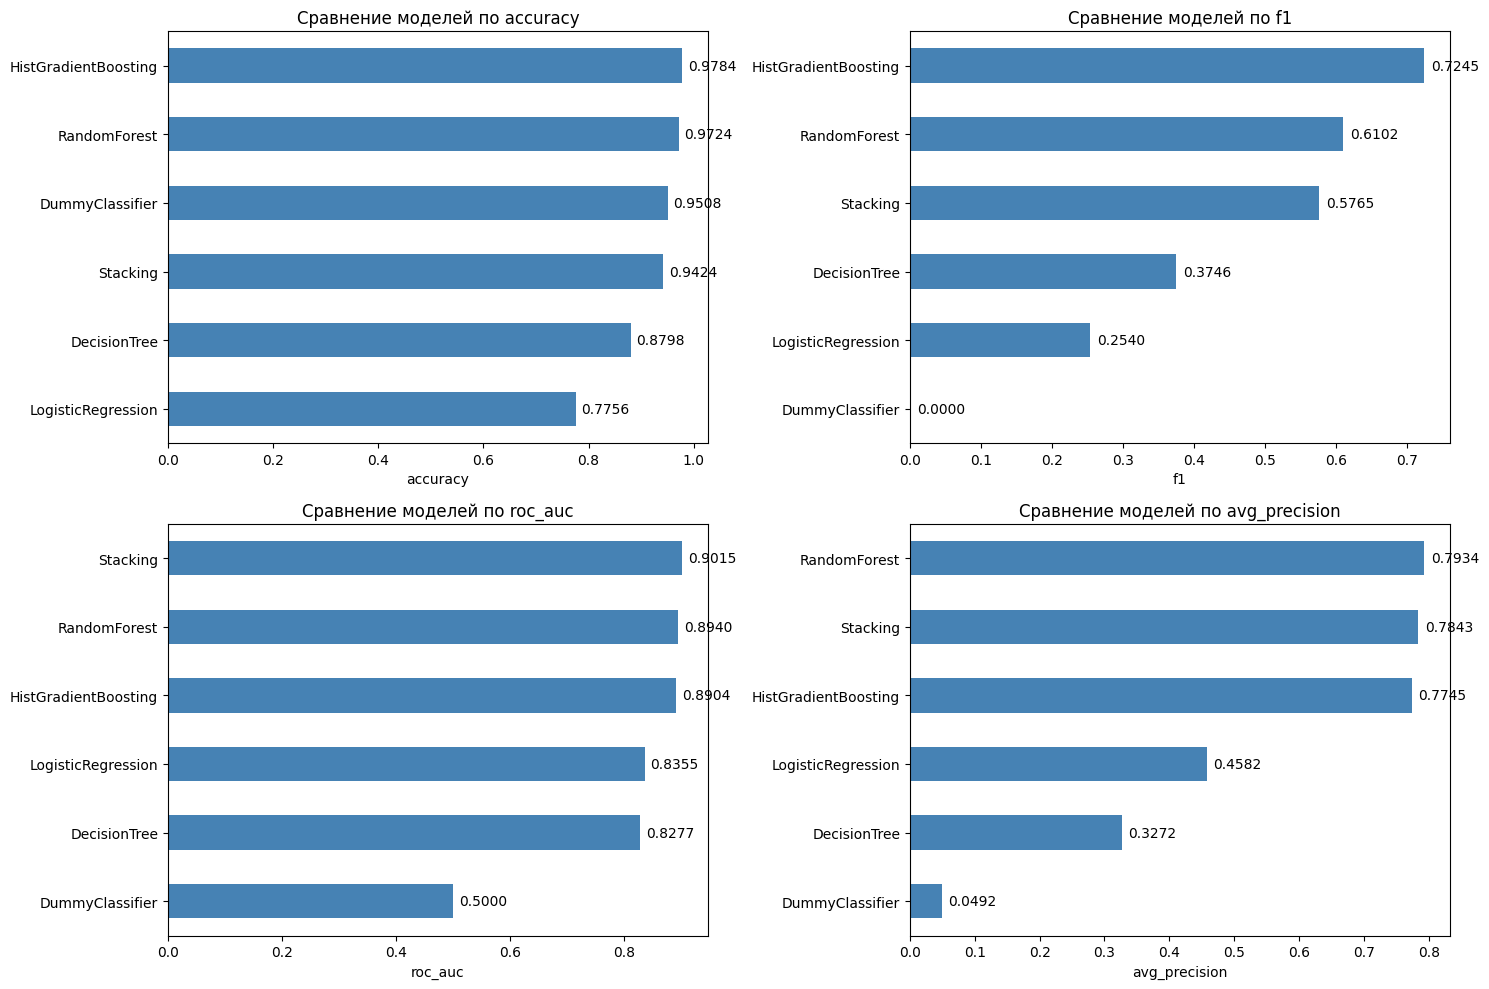


Лучшая модель по ROC-AUC: Stacking (ROC-AUC = 0.9015)


In [33]:
metrics_df = pd.DataFrame(all_metrics).T
print("Сравнение метрик всех моделей:")
display(metrics_df.sort_values('roc_auc', ascending=False))

# Визуализация сравнения
fig, axes = plt.subplots(2, 2, figsize=(15, 10))
metrics_to_plot = ['accuracy', 'f1', 'roc_auc', 'avg_precision']

for idx, metric in enumerate(metrics_to_plot):
    ax = axes[idx // 2, idx % 2]
    metrics_df[metric].sort_values().plot(kind='barh', ax=ax, color='steelblue')
    ax.set_title(f'Сравнение моделей по {metric}')
    ax.set_xlabel(metric)
    for i, v in enumerate(metrics_df[metric].sort_values()):
        ax.text(v + 0.01, i, f'{v:.4f}', va='center')

plt.tight_layout()
plt.savefig('artifacts/figures/model_comparison.png', dpi=100, bbox_inches='tight')
plt.show()

# Определяем лучшую модель по ROC-AUC
best_model_name = metrics_df['roc_auc'].idxmax()
best_model_score = metrics_df.loc[best_model_name, 'roc_auc']
print(f"\nЛучшая модель по ROC-AUC: {best_model_name} (ROC-AUC = {best_model_score:.4f})")


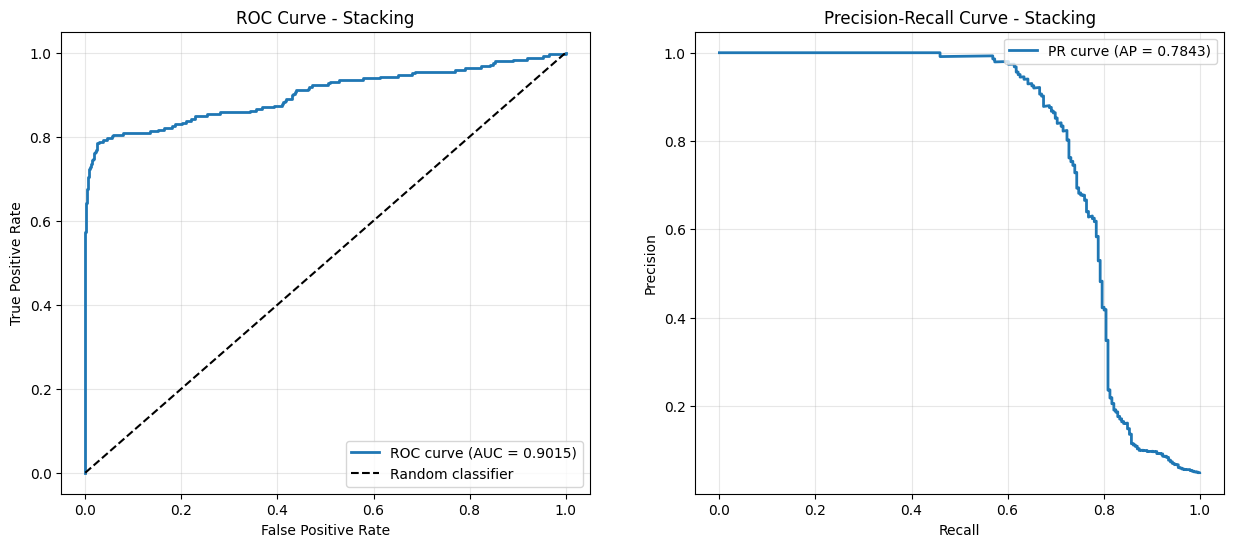

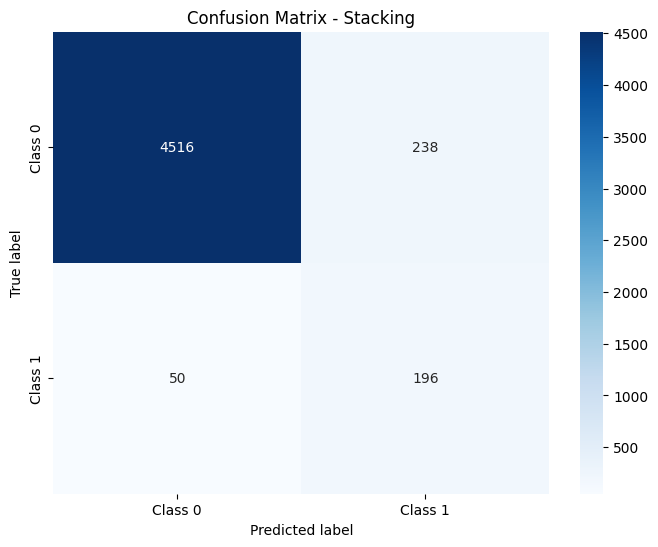

Classification Report for Stacking:
              precision    recall  f1-score   support

     Class 0       0.99      0.95      0.97      4754
     Class 1       0.45      0.80      0.58       246

    accuracy                           0.94      5000
   macro avg       0.72      0.87      0.77      5000
weighted avg       0.96      0.94      0.95      5000



In [ ]:
if best_model_name == 'DecisionTree':
    best_model = dt_best
elif best_model_name == 'RandomForest':
    best_model = rf_best
elif best_model_name == 'HistGradientBoosting':
    best_model = hgb_best
elif best_model_name == 'Stacking':
    best_model = stacking
elif best_model_name == 'LogisticRegression':
    best_model = logreg_pipeline
else:
    best_model = dummy

y_proba_best = best_model.predict_proba(X_test)[:, 1]

fpr, tpr, _ = roc_curve(y_test, y_proba_best)
roc_auc = roc_auc_score(y_test, y_proba_best)

precision, recall, _ = precision_recall_curve(y_test, y_proba_best)
avg_precision = average_precision_score(y_test, y_proba_best)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

ax1.plot(fpr, tpr, label=f'ROC curve (AUC = {roc_auc:.4f})', linewidth=2)
ax1.plot([0, 1], [0, 1], 'k--', label='Random classifier')
ax1.set_xlabel('False Positive Rate')
ax1.set_ylabel('True Positive Rate')
ax1.set_title(f'ROC Curve - {best_model_name}')
ax1.legend(loc='lower right')
ax1.grid(True, alpha=0.3)

ax2.plot(recall, precision, label=f'PR curve (AP = {avg_precision:.4f})', linewidth=2)
ax2.set_xlabel('Recall')
ax2.set_ylabel('Precision')
ax2.set_title(f'Precision-Recall Curve - {best_model_name}')
ax2.legend(loc='upper right')
ax2.grid(True, alpha=0.3)

plt.savefig(f'artifacts/figures/{best_model_name}_curves.png', dpi=100, bbox_inches='tight')
plt.show()

y_pred_best = best_model.predict(X_test)
cm = confusion_matrix(y_test, y_pred_best)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Class 0', 'Class 1'],
            yticklabels=['Class 0', 'Class 1'])
plt.title(f'Confusion Matrix - {best_model_name}')
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.savefig(f'artifacts/figures/{best_model_name}_confusion_matrix.png', dpi=100, bbox_inches='tight')
plt.show()

print(f"Classification Report for {best_model_name}:")
print(classification_report(y_test, y_pred_best, target_names=['Class 0', 'Class 1']))


Вычисляем Permutation Importance для Stacking...


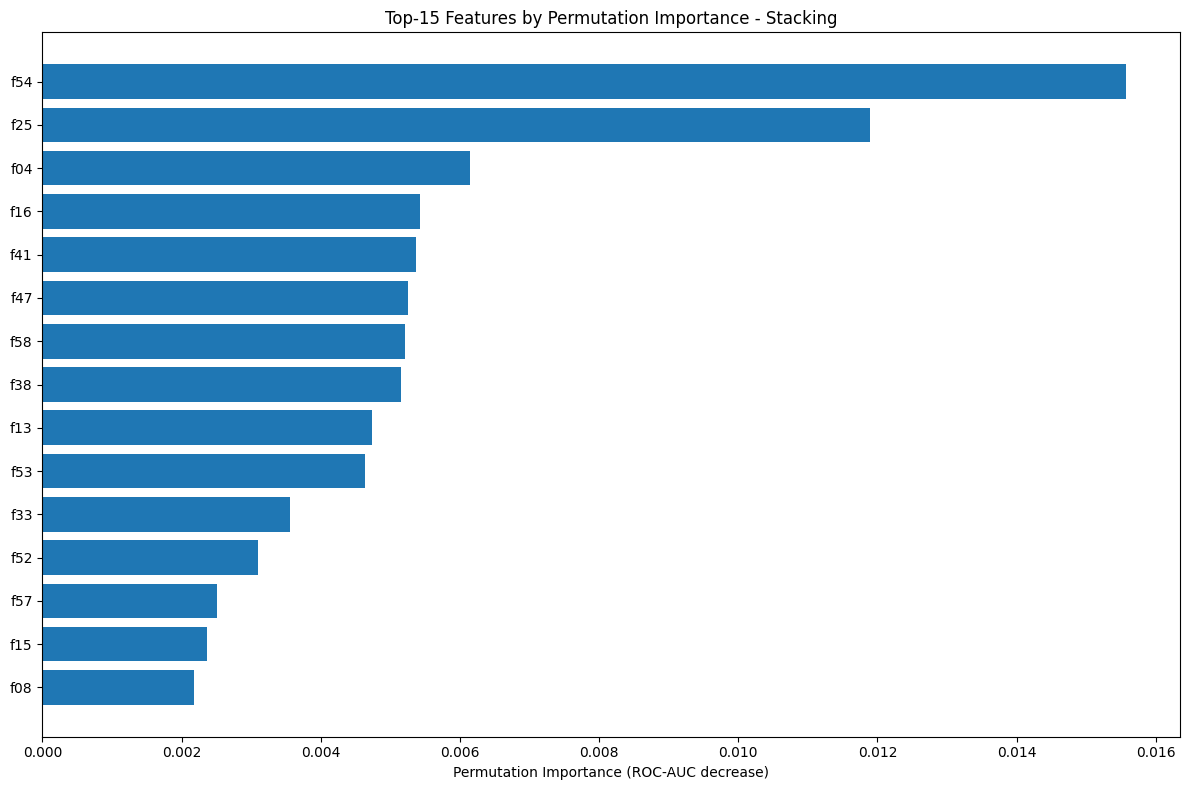


Топ-15 важнейших признаков:
1. f54
2. f25
3. f04
4. f16
5. f41
6. f47
7. f58
8. f38
9. f13
10. f53
11. f33
12. f52
13. f57
14. f15
15. f08


In [35]:
print(f"Вычисляем Permutation Importance для {best_model_name}...")

# Для больших моделей используем меньше итераций
n_repeats = 10 if best_model_name in ['RandomForest', 'Stacking'] else 20

perm_importance = permutation_importance(
    best_model, X_test, y_test,
    n_repeats=n_repeats,
    random_state=RANDOM_STATE,
    scoring='roc_auc',
    n_jobs=-1
)

# Сортируем признаки по важности
sorted_idx = perm_importance.importances_mean.argsort()[::-1]
top_n = min(15, len(sorted_idx))  # Берем топ-15 признаков

# График permutation importance
plt.figure(figsize=(12, 8))
plt.barh(range(top_n), perm_importance.importances_mean[sorted_idx[:top_n]][::-1])
plt.yticks(range(top_n), X.columns[sorted_idx[:top_n]][::-1])
plt.xlabel("Permutation Importance (ROC-AUC decrease)")
plt.title(f"Top-{top_n} Features by Permutation Importance - {best_model_name}")
plt.tight_layout()
plt.savefig(f'artifacts/figures/{best_model_name}_permutation_importance.png', dpi=100, bbox_inches='tight')
plt.show()

# Сохраняем топ-признаки
top_features = X.columns[sorted_idx[:top_n]].tolist()
print(f"\nТоп-{top_n} важнейших признаков:")
for i, feat in enumerate(top_features, 1):
    print(f"{i}. {feat}")


Permutation importance показала, что модель StackingClassifier выделил 5 ключевых признаков (f54, f25, f04, f16, f41), которые отвечают за основную предсказательную силу, в то время как большинство остальных 55 признаков имеют минимальное влияние, что типично для задач с множеством признаков и соответствует ожиданиям для синтетических данных с сильным дисбалансом классов.

In [ ]:
metrics_dict = {}
for model_name, metrics in all_metrics.items():
    metrics_dict[model_name] = {k: float(v) for k, v in metrics.items()}

with open('artifacts/metrics_test.json', 'w') as f:
    json.dump(metrics_dict, f, indent=2)

print("Метрики сохранены в artifacts/metrics_test.json")

search_summaries = {}

if 'dt_grid' in locals():
    search_summaries['DecisionTree'] = {
        'best_params': dt_grid.best_params_,
        'best_score': float(dt_grid.best_score_)
    }

if 'rf_grid' in locals():
    search_summaries['RandomForest'] = {
        'best_params': rf_grid.best_params_,
        'best_score': float(rf_grid.best_score_)
    }

if 'hgb_grid' in locals():
    search_summaries['HistGradientBoosting'] = {
        'best_params': hgb_grid.best_params_,
        'best_score': float(hgb_grid.best_score_)
    }

search_summaries['Stacking'] = {
    'base_models': [name for name, _ in base_models],
    'meta_model': 'LogisticRegression'
}

with open('artifacts/search_summaries.json', 'w') as f:
    json.dump(search_summaries, f, indent=2)

print("Параметры моделей сохранены в artifacts/search_summaries.json")

joblib.dump(best_model, 'artifacts/best_model.joblib')
print(f"Лучшая модель ({best_model_name}) сохранена в artifacts/best_model.joblib")

best_model_meta = {
    'model_name': best_model_name,
    'best_params': str(best_model.get_params()) if hasattr(best_model, 'get_params') else 'Custom stacking',
    'test_metrics': metrics_dict[best_model_name],
    'top_features': top_features[:10],  # Топ-10 признаков
    'timestamp': datetime.now().isoformat(),
    'random_state': RANDOM_STATE,
    'dataset': 'S06-hw-dataset-04.csv',
    'dataset_shape': df.shape
}

with open('artifacts/best_model_meta.json', 'w') as f:
    json.dump(best_model_meta, f, indent=2)

print("Метаданные сохранены в artifacts/best_model_meta.json")

top_features_df = pd.DataFrame({
    'feature': top_features,
    'importance_mean': perm_importance.importances_mean[sorted_idx[:len(top_features)]],
    'importance_std': perm_importance.importances_std[sorted_idx[:len(top_features)]]
})

top_features_df.to_csv('artifacts/top_features.csv', index=False)
print("Топ-признаки сохранены в artifacts/top_features.csv")


Метрики сохранены в artifacts/metrics_test.json
Параметры моделей сохранены в artifacts/search_summaries.json
Лучшая модель (Stacking) сохранена в artifacts/best_model.joblib
Метаданные сохранены в artifacts/best_model_meta.json
Топ-признаки сохранены в artifacts/top_features.csv


In [39]:
print("=" * 70)
print("ИТОГОВЫЕ ВЫВОДЫ")
print("=" * 70)

print(f"\n1. Лучшая модель: {best_model_name}")
print(f"   ROC-AUC: {metrics_dict[best_model_name]['roc_auc']:.4f}")
print(f"   F1-Score: {metrics_dict[best_model_name]['f1']:.4f}")
print(f"   Average Precision: {metrics_dict[best_model_name]['avg_precision']:.4f}")

print("\n2. Сравнение с baseline:")
print(f"   Dummy Classifier ROC-AUC: {metrics_dict['DummyClassifier']['roc_auc']:.4f}")
print(f"   Улучшение ROC-AUC: {metrics_dict[best_model_name]['roc_auc'] - metrics_dict['DummyClassifier']['roc_auc']:.4f}")

print("\n3. Качество на миноритарном классе (класс 1):")
print(f"   Precision: {classification_report(y_test, y_pred_best, output_dict=True)['1']['precision']:.4f}")
print(f"   Recall: {classification_report(y_test, y_pred_best, output_dict=True)['1']['recall']:.4f}")

print("\n4. Анализ важности признаков:")
print("   Самые важные признаки (по permutation importance):")
for i, feat in enumerate(top_features[:5], 1):
    print(f"   {i}. {feat}")

print("\n5. Рекомендации для production:")
print("   - Использовать порог вероятности отличный от 0.5 (настроить по PR-кривой)")
print("   - Мониторить precision/recall в зависимости от бизнес-требований")
print("   - Рассмотреть дополнительные методы борьбы с дисбалансом (SMOTE, ансамбли)")
print("=" * 70)

ИТОГОВЫЕ ВЫВОДЫ

1. Лучшая модель: Stacking
   ROC-AUC: 0.9015
   F1-Score: 0.5765
   Average Precision: 0.7843

2. Сравнение с baseline:
   Dummy Classifier ROC-AUC: 0.5000
   Улучшение ROC-AUC: 0.4015

3. Качество на миноритарном классе (класс 1):
   Precision: 0.4516
   Recall: 0.7967

4. Анализ важности признаков:
   Самые важные признаки (по permutation importance):
   1. f54
   2. f25
   3. f04
   4. f16
   5. f41

5. Рекомендации для production:
   - Использовать порог вероятности отличный от 0.5 (настроить по PR-кривой)
   - Мониторить precision/recall в зависимости от бизнес-требований
   - Рассмотреть дополнительные методы борьбы с дисбалансом (SMOTE, ансамбли)
